# Predicting bike sharing patterns using a neural network

In this project, I'll build a neural network and use it to predict daily bike rental ridership.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and prepare the data

A critical step in working with neural networks is preparing the data correctly. Variables on different scales make it difficult for the network to efficiently learn the correct weights.

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


## Checking out the data

This dataset has the number of riders for each hour of each day from January 1 2011 to December 31 2012. The number of riders is split between casual and registered, summed up in the `cnt` column.

Below is a plot showing the number of bike riders over the first 10 days or so in the data set. (Some days don't have exactly 24 entries in the data set, so it's not exactly 10 days.) It is possible to see the hourly rentals here. The weekends have lower over all ridership and there are spikes when people are biking to and from work during the week. Looking at the data above, we also have information about temperature, humidity, and windspeed, all of these likely affect the number of riders.

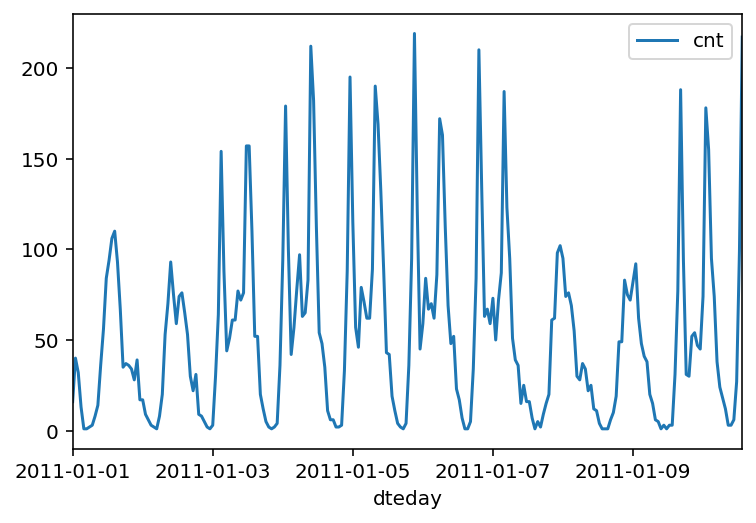

In [4]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables
There are some categorical variables like season, weather, month. To include these in the model, I'll need to make binary dummy variables. This is simple to do with Pandas thanks to `get_dummies()`.

In [5]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables
To make training the network easier, I'll standardize each of the continuous variables. That is, I'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so I can go backwards when I use the network for predictions.

In [6]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

I'll save the data for the last approximately 21 days to use as a test set after I've trained the network. I'll use this set to make predictions and compare them with the actual number of riders.

In [7]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

I'll split the data into two sets, one for training and one for validating as the network is being trained. Since this is time series data, I'll train on historical data, then try to predict on future data (the validation set).

In [8]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

## Building the network

The network has two layers: a hidden layer and an output layer. The hidden layer will use the sigmoid function for activations. The output layer has only one node and is used for the regression, the output of the node is the same as the input of the node. That is, the activation function is $f(x)=x$.

In [9]:
from my_neural_net import NeuralNetwork

In [10]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests

Run these unit tests to check the correctness of the network implementation.

In [11]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(rides, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)

.....
----------------------------------------------------------------------
Ran 5 tests in 0.013s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

Here I'll set the hyperparameters for the network. The strategy here is to find hyperparameters such that the error on the training set is low, but I'm not overfitting to the data. If I train the network too long or have too many hidden nodes, it can become overly specific to the training set and will fail to generalize to the validation set. That is, the loss on the validation set will start increasing as the training set loss drops.

I'll also be using a method known as Stochastic Gradient Descent (SGD) to train the network. The idea is that for each training pass, I grab a random sample of the data instead of using the whole data set. I use many more training passes than with normal gradient descent, but each pass is much faster. This ends up training the network more efficiently.

In [12]:
##########################################################
# Set hyperparameters
##########################################################
iterations = 100000
learning_rates_list = [0.001, 0.01, 0.1, 0.5]
hidden_nodes_list = [2, 8, 16, 32, 64]
output_nodes = 1

In [13]:
import sys
import copy
import math
import pickle

def is_monotonically_increasing(sequence_list):
    return all(i <= j for i, j in zip(sequence_list, sequence_list[1:]))

best_network = None
best_net_losses = {'train':[], 'validation':[], 'test':[]}
best_learning_rate = None
best_hidden_nodes = None
best_test_loss = None
best_train_loss = None
best_val_loss = math.inf

networks_list = []
losses = {'train':[], 'validation':[], 'test':[]}

N_i = train_features.shape[1]

for learning_rate in learning_rates_list:
    for hidden_nodes in hidden_nodes_list:
        print(f'\n\n========== CURRENT TRAINING NET: learning rate of {learning_rate} and {hidden_nodes} hidden node(s) ==========')
        print(f'Current best net: learning rate of {best_learning_rate}, {best_hidden_nodes} hidden node(s), train loss of {best_train_loss}, val loss of {best_val_loss} and test loss of {best_test_loss}')
        
        network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

        losses['train'].clear()
        losses['validation'].clear()
        losses['test'].clear()
        networks_list.clear()
        for ii in range(iterations):
            # Go through a random batch of 128 records from the training data set
            batch = np.random.choice(train_features.index, size=128)
            X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['cnt']

            network.train(X, y)

            # Printing out the training progress
            train_loss = MSE(network.run(train_features).T, train_targets['cnt'].values)
            val_loss = MSE(network.run(val_features).T, val_targets['cnt'].values)
            test_loss = MSE(network.run(test_features).T, test_targets['cnt'].values)
            sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                             + "% ... Training loss: " + str(train_loss)[:5] \
                             + " ... Validation loss: " + str(val_loss)[:5] \
                             + " ... Test loss: " + str(test_loss)[:5])
            sys.stdout.flush()

            losses['train'].append(train_loss)
            losses['validation'].append(val_loss)
            losses['test'].append(test_loss)
            networks_list.append(copy.deepcopy(network))
            
            # Check if training should be interrupted based on the last 50 losses - early stopping
            if (is_monotonically_increasing(losses['train'][-50:]) or is_monotonically_increasing(losses['validation'][-50:])) and ii >= 50:
                print('\nInterrupting training process because the losses are not getting any better!')
                break
        
        # Update best network
        min_val_loss = min(losses['validation'])
        if min_val_loss < best_val_loss:
            index_of_smallest_val_loss = losses['validation'].index(min_val_loss)
            
            best_net_losses['train'] = copy.deepcopy(losses['train'])
            best_net_losses['validation'] = copy.deepcopy(losses['validation'])
            best_net_losses['test'] = copy.deepcopy(losses['test'])
            
            best_val_loss = min_val_loss
            best_train_loss = best_net_losses['train'][index_of_smallest_val_loss]
            best_test_loss = best_net_losses['test'][index_of_smallest_val_loss]
            
            best_network = copy.deepcopy(networks_list[index_of_smallest_val_loss])
            
            best_learning_rate = learning_rate
            best_hidden_nodes = hidden_nodes

print('\n\n\n==================== BEST NEURAL NETWORK\'S INFO ====================')

print(f'Hidden nodes: {best_hidden_nodes}')
print(f'Learning rate: {best_learning_rate}')
print(f'Train loss: {best_train_loss}')
print(f'Validation loss: {best_val_loss}')
print(f'Test loss: {best_test_loss}')

with open('best_net.pickle', 'wb') as f:
    pickle.dump([best_network.weights_hidden_to_output, best_network.weights_input_to_hidden, best_learning_rate, best_hidden_nodes, best_train_loss, best_val_loss, best_test_loss, best_net_losses, index_of_smallest_val_loss, scaled_features], f)



========== CURRENT TRAINING NET: learning rate of 0.001 and 2 hidden node(s) ==========
Current best net: learning rate of None, None hidden node(s), train loss of None, val loss of inf and test loss of None
Progress: 2.0% ... Training loss: 1.009 ... Validation loss: 1.259 ... Test loss: 0.898
Interrupting training process because the losses are not getting any better!


========== CURRENT TRAINING NET: learning rate of 0.001 and 8 hidden node(s) ==========
Current best net: learning rate of 0.001, 2 hidden node(s), train loss of 1.0496235220212198, val loss of 1.2546460745407375 and test loss of 0.9731784628210591
Progress: 100.0% ... Training loss: 0.305 ... Validation loss: 0.485 ... Test loss: 0.318

========== CURRENT TRAINING NET: learning rate of 0.001 and 16 hidden node(s) ==========
Current best net: learning rate of 0.001, 8 hidden node(s), train loss of 0.3058416927258291, val loss of 0.4854237239953537 and test loss of 0.31868769469156005
Progress: 100.0% ... Training lo

## Load pickle file

In [14]:
import pickle

# Open pickle file
file = open('best_net.pickle', 'rb')

# Dump information to that file
object_file = pickle.load(file)

# Close the file
file.close()

In [15]:
best_hidden_nodes = object_file[3]
best_learning_rate = object_file[2]

best_network = NeuralNetwork(train_features.shape[1], best_hidden_nodes, 1, best_learning_rate)

best_network.weights_hidden_to_output = object_file[0]
best_network.weights_input_to_hidden = object_file[1]

best_train_loss = object_file[4]
best_val_loss = object_file[5]
best_test_loss = object_file[6]
best_net_losses = object_file[7]
index_of_smallest_val_loss = object_file[8]
scaled_features = object_file[9]

## Visualizations

Let's see how the training and validation losses of the best network evolved.

Hidden nodes: 8
Learning rate: 0.5
Train loss: 0.058575024918699974
Validation loss: 0.12120967659360699
Test loss: 0.13500620208206002


c:\users\mateu\appdata\local\programs\python\python37\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\users\mateu\appdata\local\programs\python\python37\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


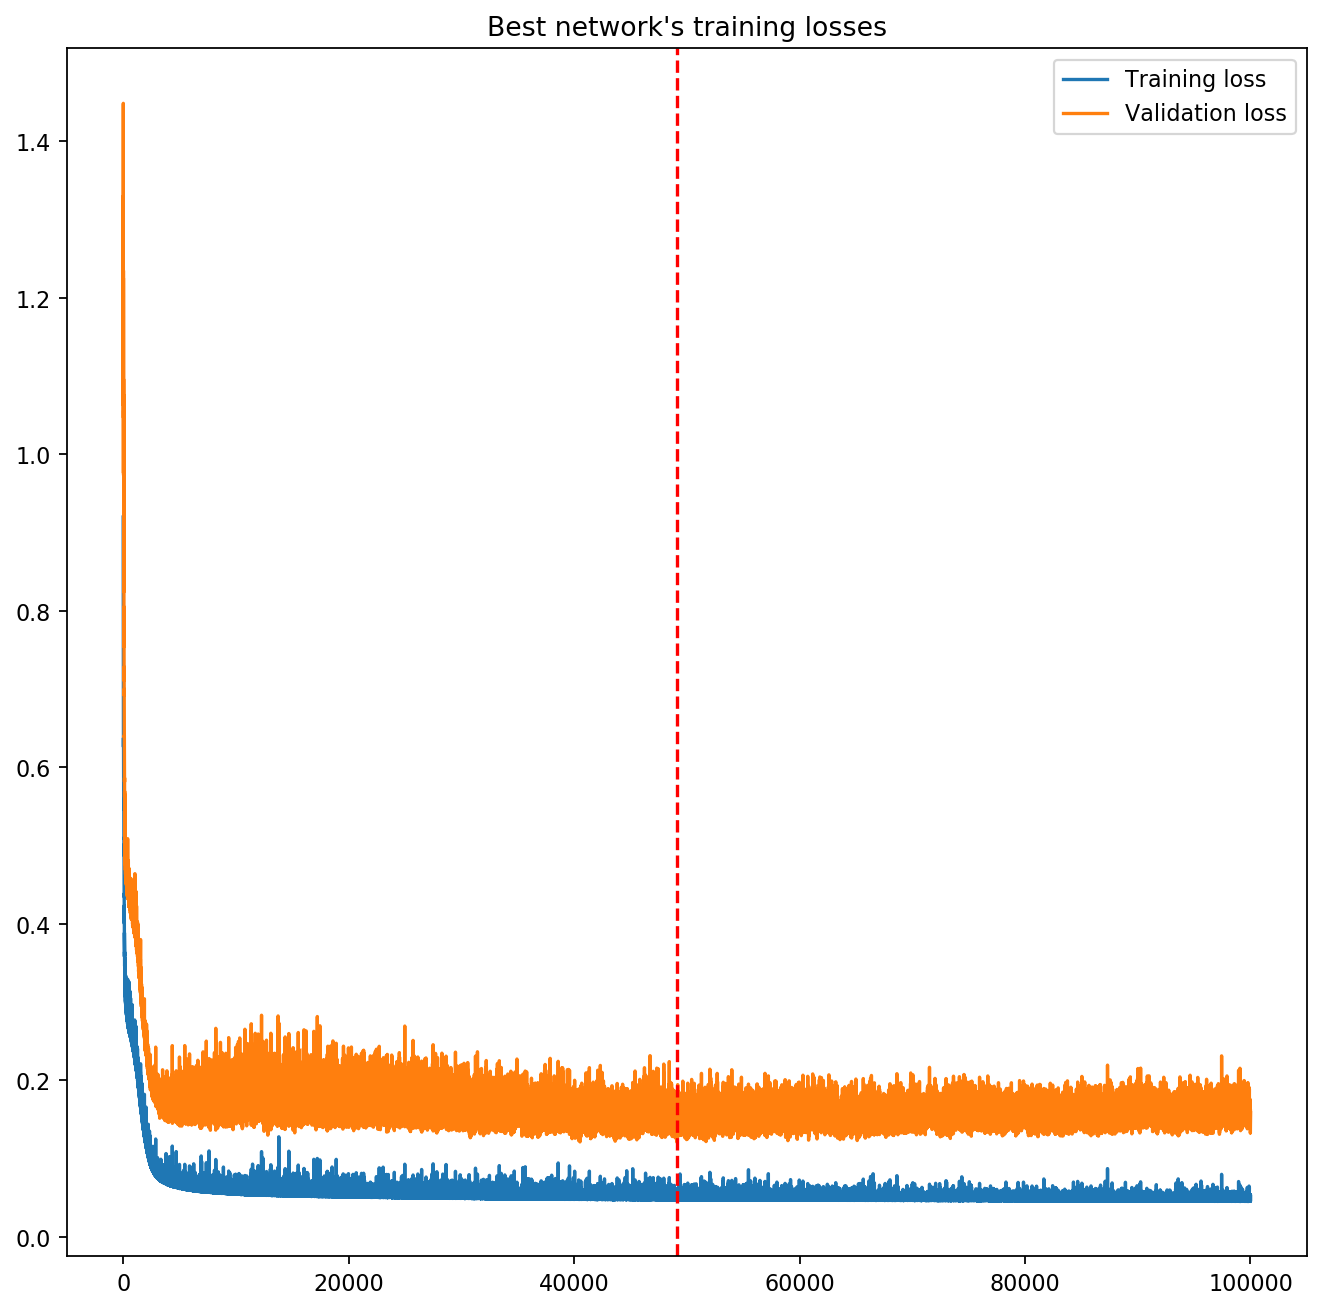

In [16]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

plt.plot(best_net_losses['train'], label='Training loss')
plt.plot(best_net_losses['validation'], label='Validation loss')
plt.axvline(x=index_of_smallest_val_loss, color='red', linestyle='--') # This is where the best neural network was chosen
plt.legend()
plt.title('Best network\'s training losses')
_ = plt.ylim()

print(f'Hidden nodes: {best_hidden_nodes}')
print(f'Learning rate: {best_learning_rate}')
print(f'Train loss: {best_train_loss}')
print(f'Validation loss: {best_val_loss}')
print(f'Test loss: {best_test_loss}')

## Check out the predictions

Here, I use the test data to view how well my network is modeling the data.

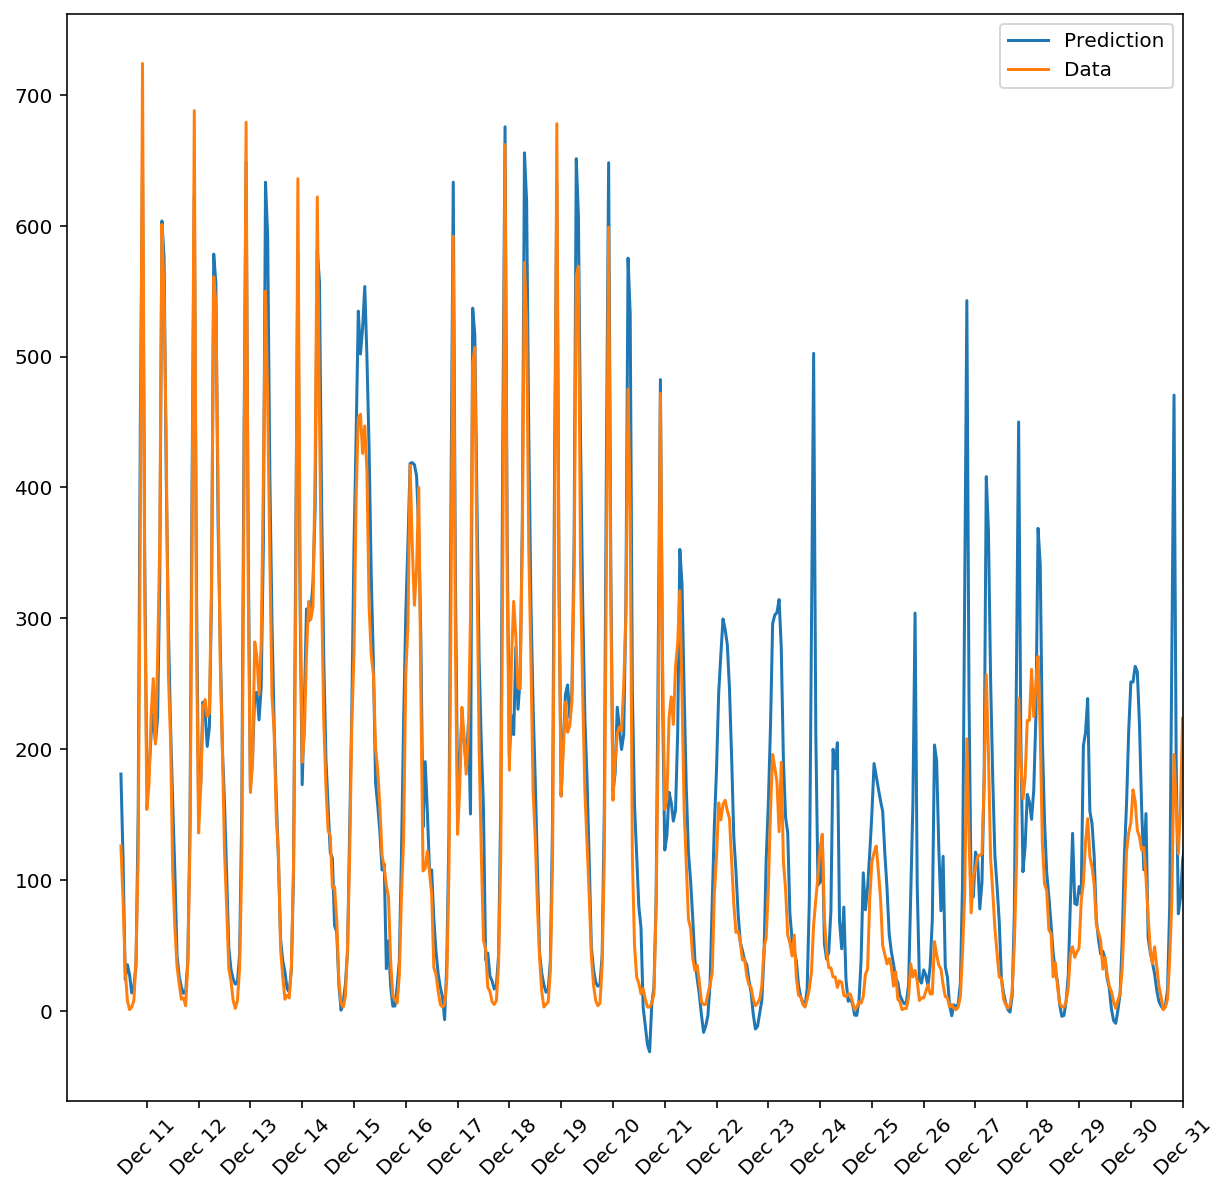

In [17]:
fig, ax = plt.subplots(figsize=(10,10))

mean, std = scaled_features['cnt']
predictions = best_network.run(test_features).T*std + mean
ax.plot(predictions[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.iloc[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

test_loss = MSE(best_network.run(test_features).T, test_targets['cnt'].values)